# Installations

# All Imports

In [1]:
import re
import numpy as np 
import pandas as pd
import textstat
import string
import nltk
from copy import deepcopy
from textblob import TextBlob
import spacy
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, KFold, StratifiedKFold, ShuffleSplit 

from sklearn.svm import LinearSVC
from sklearn import preprocessing
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.semi_supervised import SelfTrainingClassifier, LabelSpreading
from sklearn.linear_model import SGDClassifier

#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Fetch Data

In [2]:
news_group = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True)
news_group_data_test = news_group.data
news_group_target_names_test = news_group.target_names
news_group_target_test = news_group.target

# Creating a dataframe from the loaded data
news_df = pd.DataFrame({'news': news_group_data_test, 
                        'class': news_group_target_test})

# Convert to Pandas DF and Random Sampling

# Cleaning Text

*   Cleaning
*   Removing stop words



In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
import gensim
class CleanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
   
    def fit(self,X,y=None):
        return self
    
    
    
    def transform(self,X,y=None):
        # Convert to list
        data = X.tolist()

        # Remove Emails
        data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

        # Remove new line characters
        data = [re.sub('\s+', ' ', sent) for sent in data]

        # Remove distracting single quotes
        data = [re.sub("\'", "", sent) for sent in data]

        def sent_to_words(sentences):
            for sentence in sentences:
                yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        data_words = list(sent_to_words(data))
        def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
            """https://spacy.io/api/annotation"""
            texts_out = []
            for sent in texts:
                doc = nlp(" ".join(sent)) 
                texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
            return texts_out

        # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

        # Do lemmatization keeping only Noun, Adj, Verb, Adverb
        data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
        l=[]
        def detokenize(text):
            return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in text]).strip()
        for row in data_lemmatized:
            l.append(detokenize(row))
        #print(data_lemmatized[:1])
        return l

C:\Users\Vatsal\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# BOW Vectorizer

# POS Tagging

In [4]:
class POSVectorizer():
    def __init__(self):
        pass

    def creatingPOSTags(self, x):
             
        pos_family = {'NOUN' : ['NN','NNS','NNP','NNPS'],
                    'PRON' : ['PRP','PRP$','WP','WP$'], 
                    'VERB' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
                    'ADJ'  : ['JJ','JJR','JJS'],
                    'ADV'  : ['RB','RBR','RBS','WRB']
                    }
            
        count_pos = {'NOUN':0,'PRON':0,'VERB':0,'ADJ':0,'ADV':0}
        
        blob  = TextBlob(x) #converts sentences to tokens
        for tuple in blob.tags: #blob tags contains term and its pos
            #print(tuple)
            pos = list(tuple)[1]
            if pos in pos_family['NOUN']:
                count_pos['NOUN'] = count_pos.get('NOUN')+1
            elif pos in pos_family['PRON']:
                count_pos['PRON'] = count_pos.get('PRON')+1
            elif pos in pos_family['VERB']:
                count_pos['VERB'] = count_pos.get('VERB')+1
            elif pos in pos_family['ADJ']:
                count_pos['ADJ'] = count_pos.get('ADJ')+1
            elif pos in pos_family['ADV']:
                count_pos['ADV'] = count_pos.get('ADV')+1
        return count_pos 
    
    def fit(self, x, y=None):
        return self
    def transform(self, data):
        posVector = POSVectorizer()
        pos_vect = []
        for d in data:
            pos_vect.append(posVector.creatingPOSTags(d))
        return pos_vect

# Convert toArray()

In [5]:
class ToArray(BaseEstimator, TransformerMixin):

    def transform(self, X):
        return X.toarray()

    def fit(self, X, y=None, **fit_params):        
        return self

# Creating Pipelines

In [6]:
bow_transformer = Pipeline(
    steps=[
        ("cleaner", CleanTransformer()),
        ("tfidf", TfidfVectorizer()),
        ("toarray", ToArray()), #converting toarray since minmax can't handle sparce matrix
        ("scale", preprocessing.MinMaxScaler())
    ]
)


pos_transformer = Pipeline(
    steps=[
        ("cleaner", CleanTransformer()),
        ("pos", POSVectorizer()),
        ("dict_vect", DictVectorizer()),
        ("toarray", ToArray()), #converting toarray since minmax can't handle sparce matrix
        ("scale", preprocessing.MinMaxScaler())
    ]
)

combined_features = FeatureUnion(
    transformer_list=[
        ("bow", bow_transformer),
        ("pos", pos_transformer),
    ]
)



In [7]:
X=bow_transformer.fit_transform(news_df['news'])

In [9]:
print(X.shape)

(18846, 72910)


In [10]:
X_new=SelectKBest(chi2, k=5000).fit_transform(X,news_df['class'])

In [11]:
Y=pos_transformer.fit_transform(news_df['news'])

In [13]:
print(Y.shape)

(18846, 5)


In [15]:
features=np.concatenate((X_new,Y),axis=1)

# RandomForest

# EM

In [27]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np

from copy import deepcopy
from scipy.sparse import csr_matrix, vstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from scipy.linalg import get_blas_funcs
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

class Semi_EM_MultinomialNB():
    """
    Naive Bayes classifier for multinomial models for semi-supervised learning.
    
    Use both labeled and unlabeled data to train NB classifier, update parameters
    using unlabeled data, and all data to evaluate performance of classifier. Optimize
    classifier using Expectation-Maximization algorithm.
    """
    def __init__(self, alpha=1.0, fit_prior=True, class_prior=None, max_iter=30, tol=1e-6, print_log_lkh=True):
        self.alpha = alpha
        self.fit_prior = fit_prior
        self.class_prior = class_prior
        self.clf = MultinomialNB(alpha=self.alpha, fit_prior=self.fit_prior, class_prior=self.class_prior)
        self.log_lkh = -np.inf # log likelihood
        self.max_iter = max_iter # max number of EM iterations
        self.tol = tol # tolerance of log likelihood increment
        self.feature_log_prob_ = np.array([]) # Empirical log probability of features given a class, P(x_i|y).
        self.coef_ = np.array([]) # Mirrors feature_log_prob_ for interpreting MultinomialNB as a linear model.
        self.print_log_lkh = print_log_lkh # if True, print log likelihood during EM iterations

    def fit(self, X_l, y_l, X_u):
        """
        Initialize the parameter using labeled data only.
        Assume unlabeled class as missing values, apply EM on unlabeled data to refine classifier.
        """
        n_ul_docs = X_u.shape[0] # number of unlabeled samples
        n_l_docs = X_l.shape[0] # number of labeled samples
        # initialization (n_docs = n_ul_docs)
        clf = deepcopy(self.clf)# build new copy of classifier
        clf.fit(X_l, y_l) # use labeled data only to initialize classifier parameters
        prev_log_lkh = self.log_lkh # record log likelihood of previous EM iteration
        lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
        b_w_d = (X_u > 0) # words in each document [n_docs, n_words]
        lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.T]) # log CP of doc given class [n_classes, n_docs]
        lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.T) 
        lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
        lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
        lp_dc = lp_d_c + lp_c # joint prob of doc and class [n_classes, n_docs]
        p_c_d = clf.predict_proba(X_u) # weight of each class in each doc [n_docs, n_classes]
        expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
        expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
        self.clf = deepcopy(clf)
        self.log_lkh = expectation
        if self.print_log_lkh:
            print("Initial expected log likelihood = %0.3f\n" % expectation)
        # Loop until log likelihood does not improve
        iter_count = 0 # count EM iteration
        while (self.log_lkh-prev_log_lkh>=self.tol and iter_count<self.max_iter):
        # while (iter_count<self.max_iter):
            iter_count += 1
            if self.print_log_lkh:
                print("EM iteration #%d" % iter_count) # debug
            # E-step: Estimate class membership of unlabeled documents
            y_u = clf.predict(X_u)
            # M-step: Re-estimate classifier parameters
            X = vstack([X_l, X_u])
            y = np.concatenate((y_l, y_u), axis=0)
            clf.fit(X, y)
            # check convergence: update log likelihood
            p_c_d = clf.predict_proba(X_u)
            lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
            b_w_d = (X_u > 0) # words in each document
            lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.transpose()]) # log CP of doc given class [n_classes, n_docs]
            lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.transpose()) 
            lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
            lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
            lp_dc = lp_d_c + lp_c  # joint prob of doc and class [n_classes, n_docs]
            expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
            expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
            if self.print_log_lkh:
                print("\tExpected log likelihood = %0.3f" % expectation)
            if (expectation-self.log_lkh >= self.tol):
                prev_log_lkh = self.log_lkh
                self.log_lkh = expectation
                self.clf = deepcopy(clf)
            else:
                break
        self.feature_log_prob_ = self.clf.feature_log_prob_
        self.coef_ = self.clf.coef_
        return self

   
    def predict(self, X):
        return self.clf.predict(X)

    def score(self, X, y):
        return self.clf.score(X, y)

    def get_params(deep=True):
        return self.clf.get_params(deep)

    def __str__(self):
        return self.clf.__str__()

# EM Run

In [17]:
def cross_validation(clf, data_X, data_y, unlabeled,X_u, n_folds=5):
    print('=' * 80)
    print("Validation: ")
    print(clf)
    kf = StratifiedKFold(n_splits=n_folds)
    start_time = time()
    train_scores = list() # training accuracy
    fold_count = 1
    original_clf = deepcopy(clf)
    avg_accuracy = 0
    for train_ids, valid_ids in kf.split(data_X, data_y):
        cv_clf = deepcopy(original_clf)
        print("Fold # %d" % fold_count)
        fold_count += 1
        train_X, train_y, valid_X, valid_y = data_X[train_ids], data_y[train_ids], data_X[valid_ids], data_y[valid_ids]
        if unlabeled==True:
            cv_clf.fit(train_X, train_y, X_u)
        else:
            cv_clf.fit(train_X, train_y)
        pred = cv_clf.predict(valid_X)
        scores = dict()
        scores['accuracy'] = metrics.accuracy_score(valid_y, pred)
        scores['recall'] = metrics.recall_score(valid_y, pred, average='macro')
        scores['precision'] = metrics.precision_score(valid_y, pred, average='macro')
        scores['f1_score'] = metrics.f1_score(valid_y, pred, average='macro')
        train_scores.append(scores)
        avg_accuracy += scores['accuracy']
    train_time = time() - start_time
    print("Validation time: %0.3f seconds" % train_time)
    print("Average training accuracy: %0.3f" % (avg_accuracy/n_folds))
    return train_scores, train_time

In [18]:
def show_topK(classifier, vectorizer, categories, K=10):
    feature_names = np.asarray(vectorizer.get_feature_names())
    nrows, ncols = 5, 4
    fig, axes = plt.subplots(figsize=(50, 40), nrows=nrows, ncols=ncols)
    #d = path.dirname(__file__)
    circle_mask = np.array(Image.open(path.join('./', "circle.png")))
    for i, category in enumerate(categories):
        topK = np.argsort(classifier.coef_[i])[-K:]
        text = " ".join(feature_names[topK])
        print("%s: %s" % (category, text))
        wordcloud = WordCloud(background_color="white", mask=circle_mask).generate(text)
        axes[i//ncols, i%ncols].imshow(wordcloud, cmap=plt.cm.cool_r, interpolation='bilinear')
        axes[i//ncols, i%ncols].axis("off")
        axes[i//ncols, i%ncols].set_title(category, fontweight="bold", size=24)
    plt.show()

In [19]:
train_X, test_X, train_y, test_y = train_test_split(features,news_df['class'], test_size=0.2, stratify=news_df['class'])
print("Training set size: %8d\tTest set size: %8d" % (len(train_X), len(test_X)))
# Divide train data set into labeled and unlabeled data sets
X_l, X_u, y_l, y_u = train_test_split(train_X, train_y, test_size=10000, stratify=train_y)
experiments = np.logspace(2.3, 3.7, num=20, base=10, dtype='int')
print (X_l.shape, X_u.shape)

Training set size:    15076	Test set size:     3770
(5076, 5005) (10000, 5005)


In [24]:
y_l=y_l.to_numpy()
y_u=y_u.to_numpy()
print(type(X_l),type(X_u),type(y_l),type(y_u))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [25]:
from time import time
# Cross validation for Naive Bayes classifier 
# using labeled data set only
nb_cv_scores = list()
nb_cv_times = list()
for n_l_docs in experiments:
    nb_clf = MultinomialNB(alpha=1e-2)
    cv_scores, cv_time = cross_validation(nb_clf, X_l[:n_l_docs,], y_l[:n_l_docs],False,X_u)
    nb_cv_scores.append(cv_scores)
    nb_cv_times.append(cv_time)
    print("Number of labeled documents: %6d" % n_l_docs)

Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.136 seconds
Average training accuracy: 0.392
Number of labeled documents:    199
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4


C:\Users\Vatsal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vatsal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vatsal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vatsal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: Undefi

Fold # 5
Validation time: 0.060 seconds
Average training accuracy: 0.394
Number of labeled documents:    236
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.068 seconds
Average training accuracy: 0.436
Number of labeled documents:    280
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.083 seconds
Average training accuracy: 0.453
Number of labeled documents:    331
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2


C:\Users\Vatsal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vatsal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vatsal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vatsal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: Undefi

Fold # 3
Fold # 4
Fold # 5
Validation time: 0.083 seconds
Average training accuracy: 0.499
Number of labeled documents:    393
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.084 seconds
Average training accuracy: 0.506
Number of labeled documents:    466
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3

C:\Users\Vatsal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vatsal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold # 4
Fold # 5
Validation time: 0.116 seconds
Average training accuracy: 0.553
Number of labeled documents:    552
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.126 seconds
Average training accuracy: 0.561
Number of labeled documents:    654
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.132 seconds
Average training accuracy: 0.574
Number of labeled documents:    775
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2


C:\Users\Vatsal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vatsal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold # 3
Fold # 4
Fold # 5
Validation time: 0.154 seconds
Average training accuracy: 0.601
Number of labeled documents:    918
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.209 seconds
Average training accuracy: 0.607
Number of labeled documents:   1088
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.204 seconds
Average training accuracy: 0.621
Number of labeled documents:   1289
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.229 seconds
Average training accuracy: 0.629
Number of labeled documents:   1528
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.273 seconds
Average training accuracy: 0.648
Number of labeled documents:   1810
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.363 seconds
Average training accur

In [28]:
# Cross validation for semisupervised EM Naive Bayes classifier 
# using both labeled and unlabeled data set
em_nb_cv_scores = list()
em_nb_cv_times = list()
for n_l_docs in experiments:
    em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False) # semi supervised EM based Naive Bayes classifier
    cv_scores, cv_time = cross_validation(em_nb_clf, X_l[:n_l_docs,], y_l[:n_l_docs],True,X_u)
    em_nb_cv_scores.append(cv_scores)
    em_nb_cv_times.append(cv_time)
    print("Number of labeled documents: %6d" % n_l_docs)

Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 54.453 seconds
Average training accuracy: 0.528
Number of labeled documents:    199
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 56.933 seconds
Average training accuracy: 0.500
Number of labeled documents:    236
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 52.037 seconds
Average training accuracy: 0.579
Number of labeled documents:    280
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 47.891 seconds
Average training accuracy: 0.562
Number of labeled documents:    331
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 50.208 seconds
Average training accuracy: 0.555
Number of labeled documents:    393
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4


Text(0.5, 1.0, 'Cross-Validation Average Accuracy vs Number of Labeled Documents in Training Set')

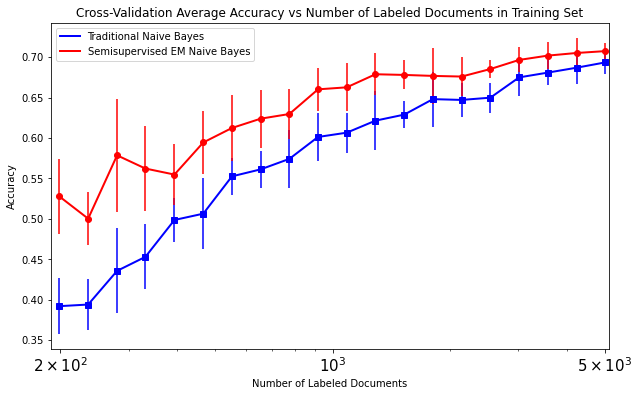

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
# plot CV accuracy comparisons
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['accuracy'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['accuracy'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_score_mean, color='b', linewidth=2, label='Traditional Naive Bayes')
ax.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax.plot(experiments, em_nb_score_mean, color='r', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Cross-Validation Average Accuracy vs Number of Labeled Documents in Training Set')

# SGD

In [ ]:
sdg_params = dict(alpha=1e-5, penalty='l2', loss='log')

fitFinalPipeline (SGDClassifier(**sdg_params), news_df['news'], news_df['class'])

# Mask

In [ ]:
y_mask = np.random.rand(len(news_sampled['class'])) < 0.2
y_masked_class = news_sampled
y_masked_class['class'][~y_mask] = -1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# LabelSpreading

In [ ]:
fitFinalPipeline (LabelSpreading(gamma=0.25, max_iter=50), news_sampled['news'], y_masked_class['class'], news_sampled_test['news'], news_sampled_test['class'])

/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:292: ConvergenceWarning: max_iter=5 was reached without convergence.
  category=ConvergenceWarning


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.00      0.00      0.00        17
           2       0.06      1.00      0.11        22
           3       1.00      0.05      0.10        19
           4       0.00      0.00      0.00        21
           5       1.00      0.04      0.08        25
           6       0.00      0.00      0.00        19
           7       0.00      0.00      0.00        21
           8       0.00      0.00      0.00        21
           9       0.00      0.00      0.00        18
          10       0.00      0.00      0.00        22
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        23
          13       0.00      0.00      0.00        20
          14       0.00      0.00      0.00        30
          15       0.00      0.00      0.00        23
          16       0.00      0.00      0.00        18
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. U

# SelfTrainingClassifier

In [ ]:
sdg_params = dict(alpha=1e-5, penalty='l2', loss='log')
fitFinalPipeline (SelfTrainingClassifier(SGDClassifier(**sdg_params), verbose=True), news_sampled['news'], y_masked_class['class'], news_sampled_test['news'], news_sampled_test['class'])

End of iteration 1, added 1458 new labels.
End of iteration 2, added 127 new labels.
End of iteration 3, added 16 new labels.
End of iteration 4, added 1 new labels.
End of iteration 5, added 1 new labels.
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        18
           1       0.83      0.29      0.43        17
           2       0.52      0.64      0.57        22
           3       1.00      0.11      0.19        19
           4       0.36      0.19      0.25        21
           5       0.43      0.64      0.52        25
           6       0.60      0.63      0.62        19
           7       0.50      0.52      0.51        21
           8       0.68      0.62      0.65        21
           9       0.62      0.56      0.59        18
          10       0.54      0.68      0.60        22
          11       0.36      0.50      0.42        10
          12       0.75      0.13      0.22        23
          13       0.13      0.65    